In [1]:
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, kstest
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('cars')
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리



,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


단순선형회귀

In [4]:
yname = 'dist'

x = origin.drop(yname, axis=1)
y = origin[yname]
X = sm.add_constant(x)
fit = sm.OLS(y,X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        15:35:58   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

잔차 분석

In [5]:
y_pred = fit.predict(X)
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

회귀분석 결과 객체 안에 내장되어 있는 예측값
- predict() 메서드는 수집된 샘플 이외에 새로운 입력값에 대한 예측치를 얻고자 할 경우 사용

In [6]:
y_pred = fit.fittedvalues
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

잔차 - 직접 구하기
- 실제 종속변수에서 예측치를 뺀다.

In [7]:
residual = origin['dist'] - y_pred
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

In [8]:
#회귀분석 결과에 내장된 잔차값
residual = fit.resid
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

In [9]:
#분석 데이터에 결합
df = origin.copy()
df['y_pred'] = y_pred   #예측값
df['resid']= residual   #잔차
df.head()

,speed,dist,y_pred,resid
0,4,2,-1.849460,3.849460
1,4,10,-1.849460,11.849460
2,7,4,9.947766,-5.947766
3,7,22,9.947766,12.052234
4,8,16,13.880175,2.119825


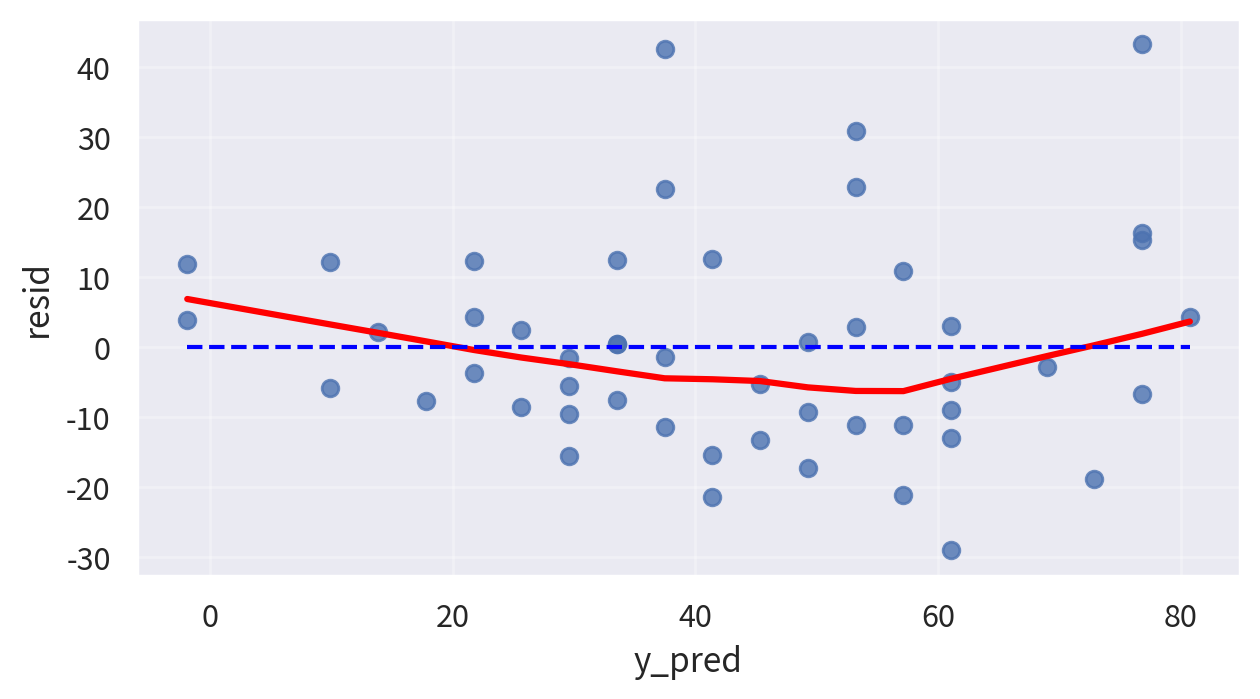

In [10]:
#잔차의 선형성 검정 - 시각화
xmin = df['y_pred'].min()
xmax = df['y_pred'].max()
xrange = [xmin, xmax]
yrange = [0,0]

width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(figsize=figsize, dpi=my_dpi)

sb.regplot(data=df, x='y_pred', y='resid', lowess=True, line_kws={'color':'red'})
sb.lineplot(x=xrange, y=yrange, color='blue', linestyle='--')

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

통계량을 통한 검정 - Ramsey RESET Test

In [11]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성/기능형 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 2.2960
p-value: 0.1364
선형성/기능형 위배 근거 없음 (5% 유의수준)


잔차의 정규성 - 시각화를 통해 검정
- Q-Q plot

In [12]:
#zscore 구하기
df['zscore'] = zscore(df['y_pred'])
df.head()

,speed,dist,y_pred,resid,zscore
0,4,2,-1.849460,3.849460,-2.177858
1,4,10,-1.849460,11.849460,-2.177858
2,7,4,9.947766,-5.947766,-1.604738
3,7,22,9.947766,12.052234,-1.604738
4,8,16,13.880175,2.119825,-1.413697


In [13]:
#Q-Q 플롯의 좌표 구하기
(x, y), _ = probplot(df['zscore'])
display(x[:5])
display(y[:5])

array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759])

array([-2.17785805, -2.17785805, -1.60473751, -1.60473751, -1.41369733])

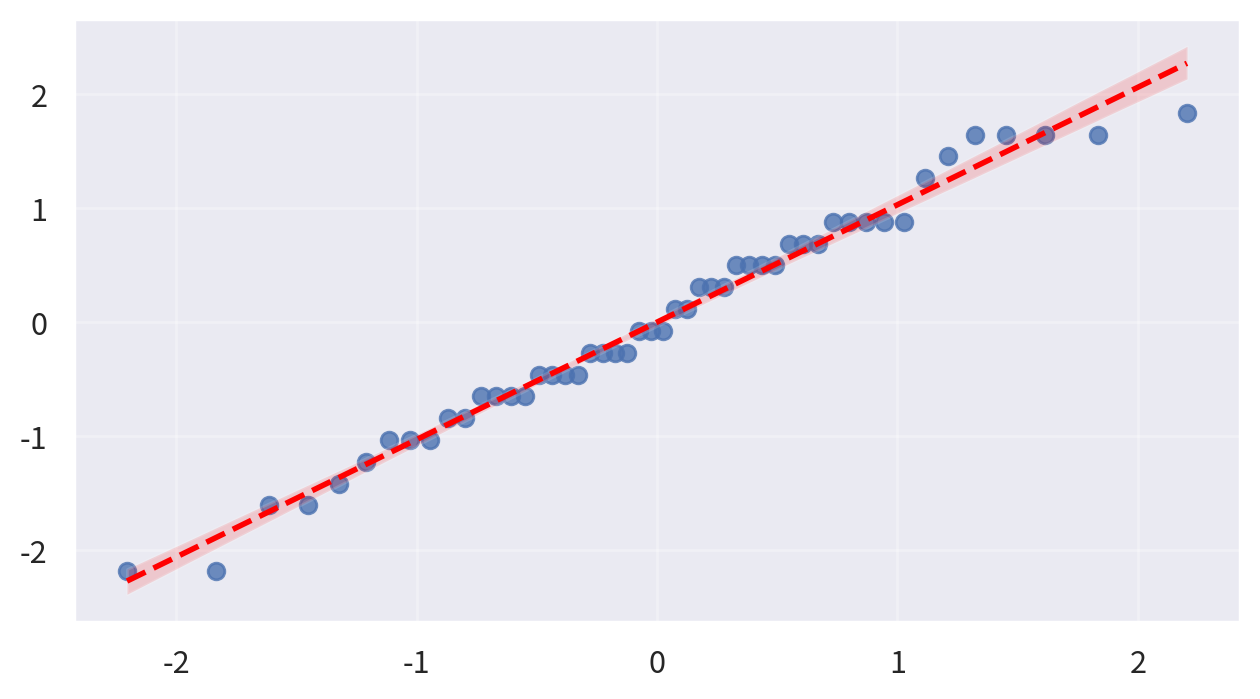

In [14]:
#Q-Q plot 그리기

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

잔차도를 통한 검정
- 잔차의 분산(MSE, Mean Squared Error of Residuals)를 통해 검정
- 잔차가 정규분포를 따른다면 대략적으로 
    - $\pm\sqrt{MSE}$ 범위 안에 최소 59% 의 잔차가 포함된다.
    - $\pm2\sqrt{MSE}$ 범위 안에 최소 68% 의 잔차가 포함된다.
    - $\pm3\sqrt{MSE}$ 범위 안에 최소 99% 의 잔차가 포함된다.




In [16]:
MSE_sq = np.sqrt(fit.mse_resid) #잔차 분산의 제곱근
r = fit.resid   #잔차

r1 = r[(r>-MSE_sq)&(r <MSE_sq)].count() / r.count() * 100
r2 = r[(r>-2*MSE_sq)&(r <2*MSE_sq)].count() / r.count() * 100
r3 = r[(r>-3*MSE_sq)&(r <3*MSE_sq)].count() / r.count() * 100

mse_r = [r1,r2,r3]

print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")

루트 1MSE 구간에 포함된 잔차 비율: 74.00%
루트 2MSE 구간에 포함된 잔차 비율: 94.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


잔차도 시각화

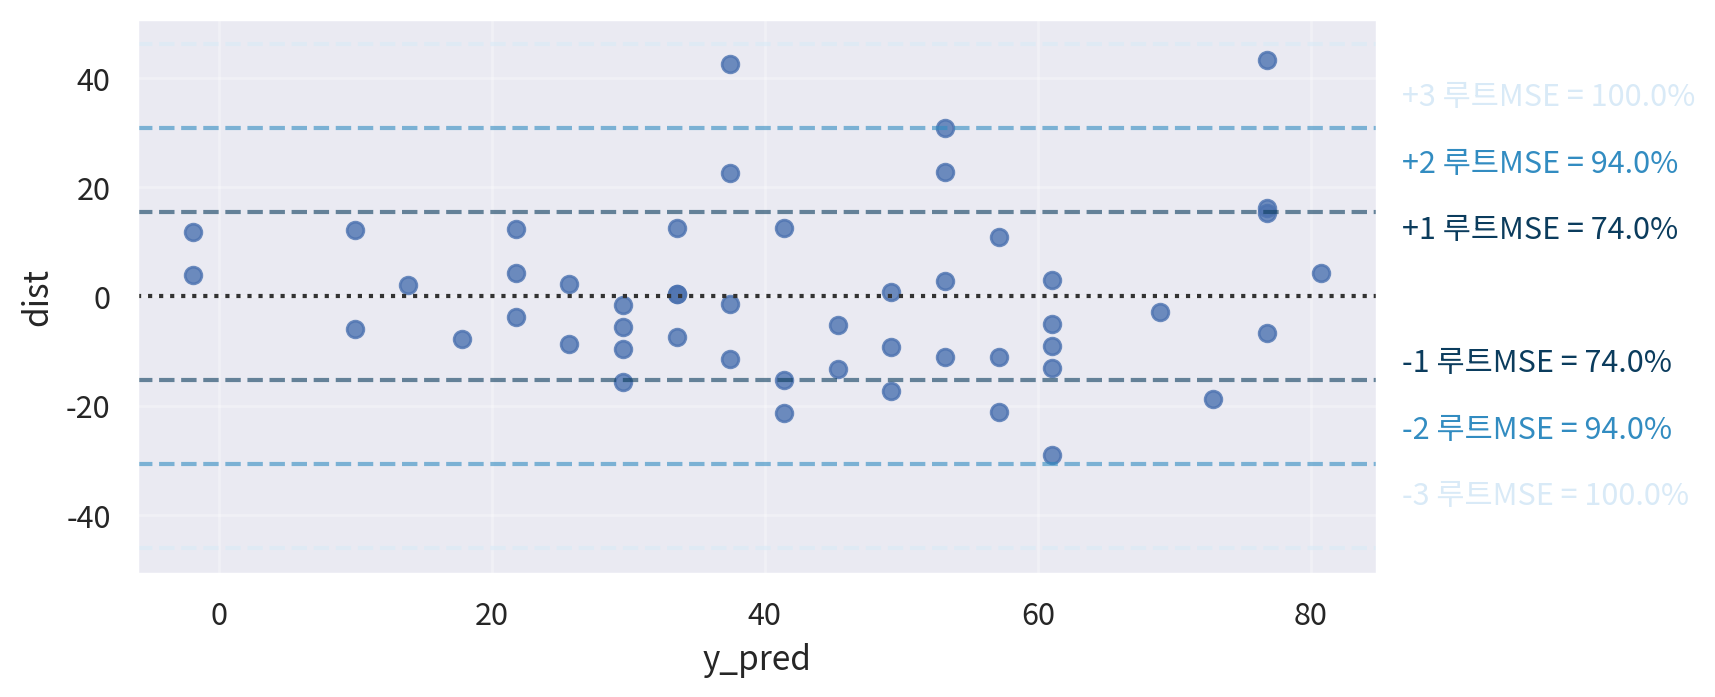

In [17]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

xmax = df['y_pred'].max()
ymin = df['y_pred'].min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, dpi=my_dpi, figsize=figsize)

sb.residplot(data = df, x='y_pred', y='dist', ax=ax)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k = i+1

    y_pos = k*mse_root
    
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} 루트MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c) 

    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} 루트MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

검정 통계량을 사용한 검정

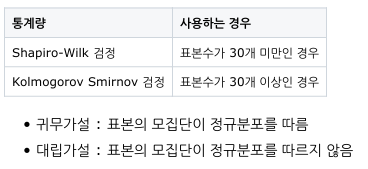

In [18]:
if len(origin) < 30:
    method = "Shapiro-Wilk"
    s, p = shapiro(df['resid'])
else:
    method = "Kolmogorov-Smirnov"

    mu = df['resid'].mean()
    sigma = df['resid'].std(ddof=1)

    s,p = kstest(df['resid'], 'norm', args=(mu, sigma))

result = f"{method} Test ::: statistic: {s:.3f}, p-value: {p:.3f}, {'대립' if p<= 0.05 else '귀무'} 가설 채택"

print(result)

Kolmogorov-Smirnov Test ::: statistic: 0.130, p-value: 0.341, 귀무 가설 채택


잔차의 등분산성 - 브로이슈-패건 검정

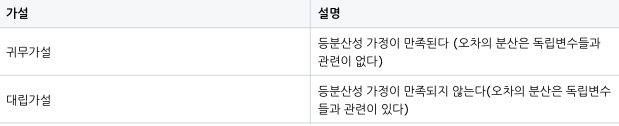

In [19]:
# Breusch-Pagan Test
names = ['LM statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

display(bp)

p_bp = bp.loc['F p-value','value']

bp_result= (
    f"Breusch-Pagan Test ::: "
    f"F = {bp.loc['F Statistic','value']:.3f}, "
    f"p-value = {p_bp:.3f}, " 
    f"{'대립' if p_bp <= 0.05 else '귀무'} 가설 채택 ->" 
    f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}"
)
print(bp_result)

,value
LM statistic,3.214880
LM p-value,0.072972
F Statistic,3.298361
F p-value,0.075597


Breusch-Pagan Test ::: F = 3.298, p-value = 0.076, 귀무 가설 채택 ->등분산성 만족


잔차의 독립성
- 회귀분석 결과표 하단의 Dubin-Watson 값을 확인한다.
- 일반적으로 DW값이 1.5 ~ 2.5 범위에 있으면 독립으로 판정

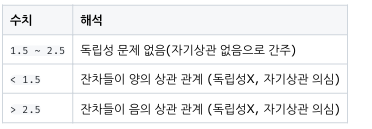

In [21]:
dw = durbin_watson(df['resid'])

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차는 양(+)의 자기상관이 존재할 가능성이 있음 (독립성 위반)"
else:
    interpretation = "잔차는 음(-)의 자기상관이 존재할 가능성이 있음 (독립성 위반)"

print(f"Durbin-Watson = {dw:.3f} ::: {interpretation}")

Durbin-Watson = 1.676 ::: 잔차는 독립성을 만족함 (자기상관 없음)


가정에 위배되면?

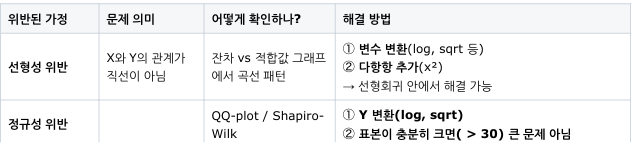
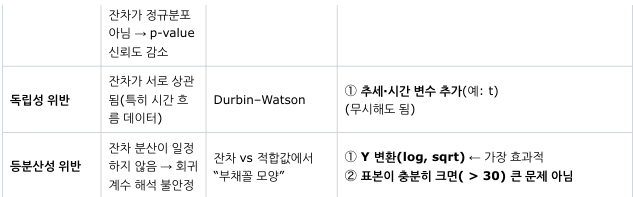